In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.model_selection import train_test_split

In [51]:
# 加载数据集中的Qd、循环寿命和总容量信息，并进行分析
temp_Qd = np.load("Data_processed/Qd_100.npy", allow_pickle=True).item()
temp_life = np.load("Data_processed/cycle_life.npy", allow_pickle=True).item()
all_capacity = np.load("Data_processed/all_capacity.npy", allow_pickle=True).item()
# 分析这个数据集里面有什么变量以及该怎么运算

In [52]:
# 该代码用于处理电池数据，提取电池寿命和相关信息，并将其转换为数组格式。
temp_Qd_all = []
temp_life_all = []

for key in temp_Qd.keys():
    temp_life_all.append(temp_life[key])
    temp_Qd_list = []
    for item in temp_Qd[key]:
        temp_Qd_list.append(item)
    temp_Qd_arr = np.asarray(temp_Qd_list)
    temp_Qd_all.append(temp_Qd_arr)

# 将所有提取的数据转换为NumPy数组
all_Qd_arr = np.asarray(temp_Qd_all)
cycle_life_arr = np.asarray(temp_life_all)

In [53]:
# 划分数据集
# 输入: temp_Qd, cycle_life_arr, all_Qd_arr
# 输出: train_Qd, val_Qd, train_cycle_life, val_cycle_life, test_Qd_a, test_cycle_life_a, test_Qd_b, test_cycle_life_b
# 功能: 将数据集划分为训练集和测试集，并进行标准化处理
test_ind = np.hstack((np.arange(0, (41 + 43), 2), 83))
train_ind = np.arange(1, (41 + 43 - 1), 2)
secondary_true_ind = np.arange(124 - 40, 124)

all_keys = list(temp_Qd.keys())
train_keys = [all_keys[inx] for inx in train_ind]
test_keys = [all_keys[inx] for inx in test_ind]
secondary_true_keys = [all_keys[inx] for inx in secondary_true_ind]

cycle_life_arr = np.asarray(cycle_life_arr).reshape(-1, 1)
max_label = np.max(cycle_life_arr)
cycle_life_arr = cycle_life_arr / max_label

train_Qds = np.asarray(all_Qd_arr)[train_ind]
train_cycle_lifes = np.asarray(cycle_life_arr)[train_ind]

test_Qd_a = np.asarray(all_Qd_arr)[test_ind]
test_cycle_life_a = np.asarray(cycle_life_arr)[test_ind]

test_Qd_b = np.asarray(all_Qd_arr)[secondary_true_ind]
test_cycle_life_b = np.asarray(cycle_life_arr)[secondary_true_ind]
train_Qd, val_Qd, train_cycle_life, val_cycle_life = train_test_split(train_Qds, train_cycle_lifes, test_size=0.2, random_state=42)

In [54]:
# 将数据转换为 torch tensors 的过程
# 训练、验证及测试数据的预处理
# 输入原始数据并将其转换为合适的形状以供模型使用
# 为了兼容模型输入，调整张量的维度
train_Qd = torch.FloatTensor(train_Qd) 
val_Qd = torch.FloatTensor(val_Qd)
train_cycle_life = torch.FloatTensor(train_cycle_life).view(-1, 1)
val_cycle_life = torch.FloatTensor(val_cycle_life).view(-1, 1)

test_Qd_a = torch.FloatTensor(test_Qd_a)
test_cycle_life_a = torch.FloatTensor(test_cycle_life_a).view(-1, 1)

test_Qd_b = torch.FloatTensor(test_Qd_b)
test_cycle_life_b = torch.FloatTensor(test_cycle_life_b).view(-1, 1)

# 增加一个维度以匹配模型的输入要求
train_Qd = train_Qd.unsqueeze(1) 
val_Qd = val_Qd.unsqueeze(1)
test_Qd_a = test_Qd_a.unsqueeze(1)
test_Qd_b = test_Qd_b.unsqueeze(1)

In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# 定义CNN-LSTM模型
class CNNLSTMModel(nn.Module):
    # 初始化模型参数
    def __init__(self, sequence_length, input_dim, hidden_dim, output_dim):
        super(CNNLSTMModel, self).__init__()
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(50, 50), stride=(5, 40)),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=1)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(2, 3), stride=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(2, 3), stride=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True)
        )
        self.feature_size = self._get_conv_output_size()

        
        # LSTM层
        self.lstm = nn.LSTM(self.feature_size, hidden_dim, batch_first=True, dropout=0.5)
        self.dropout = nn.Dropout(0.5)
        
        self.fc1 = nn.Linear(64,100)
        
        self.fc2 = nn.Linear(100,1) 
    # 计算卷积层的输出大小
    def _get_conv_output_size(self):
        input_tensor = torch.autograd.Variable(torch.rand(1, 1, self.sequence_length, self.input_dim))
        output_feat = self.layer3(self.layer2(self.layer1(input_tensor)))
        return int(output_feat.view(output_feat.size(0), -1).size(1))

    # 定义前向传播过程
    def forward(self, x):
        if x.size(1) != 1 or x.size(2) != self.sequence_length or x.size(3) != self.input_dim:
            raise ValueError(f"Input tensor shape should be [batch_size, 1, {self.sequence_length}, {self.input_dim}], but got {x.shape}")
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = x.view(x.size(0), -1, self.feature_size)
        lstm_out, _ = self.lstm(x)
        
        x = lstm_out[:, -1, :]
        x = self.dropout(x)
        x = self.fc1(x)
        x= self.fc2(x)

        return x


In [56]:
# 实例化模型
model = CNNLSTMModel(sequence_length=100, input_dim=1000, hidden_dim=64, output_dim=1)


c:\Users\Fisher Man\anaconda3\envs\py39\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [57]:
import torch
import torch.nn as nn
import numpy as np
import logging

# 设置日志配置，输出到 log 文件
logging.basicConfig(filename='training.log', 
                    filemode='w',  # 'w' 表示每次运行都会重写日志文件, 如果需要追加则使用 'a'
                    format='%(asctime)s - %(levelname)s - %(message)s', 
                    level=logging.INFO)

# 设置模型优化器、损失函数和其他参数
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# 设置 Early Stopping 参数
patience = 3  # 如果损失没有改善的轮次
best_loss = np.inf
patience_counter = 0

# 设置多线程
n_jobs = 14  # 你想使用的线程数
torch.set_num_threads(n_jobs)

# 训练模型
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    # 前向传播
    outputs = model(train_Qd)
    loss = criterion(outputs, train_cycle_life)
    
    # 反向传播和优化
    loss.backward()
    optimizer.step()

    # 记录到日志文件
    logging.info(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

    # Early Stopping 检查
    if loss.item() < best_loss:
        best_loss = loss.item()
        patience_counter = 0  # 重置 patience 计数
    else:
        patience_counter += 1  # 增加 patience 计数

    if patience_counter >= patience:
        logging.info(f"Early stopping triggered at epoch {epoch+1}")
        break


In [58]:
# 验证模型
model.eval()
with torch.no_grad():
    predicted = model(val_Qd)
    val_loss = criterion(predicted, val_cycle_life)
    print(f'Validation Loss: {val_loss.item()}')

# 测试模型
with torch.no_grad():
    predicted_a = model(test_Qd_a)
    predicted_b = model(test_Qd_b)
    test_loss_a = criterion(predicted_a, test_cycle_life_a)
    test_loss_b = criterion(predicted_b, test_cycle_life_b)
    print(f'Test Loss A: {test_loss_a.item()}')
    print(f'Test Loss B: {test_loss_b.item()}')

# 特征提取函数
def extract_features(data):
    data = data.numpy()  
    features = {
        'mean': np.mean(data, axis=0),
        'std': np.std(data, axis=0),
        'max': np.max(data, axis=0),
        'min': np.min(data, axis=0),
    }
    features_flat = [features['mean'].flatten(), features['std'].flatten(), features['max'].flatten(), features['min'].flatten()]
    return np.concatenate(features_flat)

# 相似度计算函数
def euclidean_distance(feature1, feature2):
    return np.sqrt(np.sum((feature1 - feature2) ** 2))

# 找到相似的训练LIB
def find_similar_lib(train_features, test_feature):
    min_distance = float('inf')
    similar_lib_index = None
    for i, train_feature in enumerate(train_features):
        distance = euclidean_distance(test_feature, train_feature)
        if distance < min_distance:
            min_distance = distance
            similar_lib_index = i
    return similar_lib_index

# 提取训练和测试数据的特征
train_features = [extract_features(lib) for lib in train_Qd]
test_feature = extract_features(test_Qd_a[0])  

similar_lib_index = find_similar_lib(train_features, test_feature)
print(f"The similar LIB index in training set is: {similar_lib_index}")

torch.save(model.state_dict(), 'model.pth')
model.load_state_dict(torch.load('model.pth'))

Validation Loss: 0.019769497215747833
Test Loss A: 0.06829945743083954
Test Loss B: 0.12545910477638245
The similar LIB index in training set is: 4


C:\Users\Fisher Man\AppData\Local\Temp\ipykernel_3504\2080267499.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model.pth'))


<All keys matched successfully>

In [59]:
import numpy as np
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score    # 加载模型
model.load_state_dict(torch.load('model.pth'))
model.eval()


C:\Users\Fisher Man\AppData\Local\Temp\ipykernel_3504\2944833387.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model.pth'))


CNNLSTMModel(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(50, 50), stride=(5, 40))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(2, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(2, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (lstm): LSTM(9728, 64, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=64, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=1, b

Test Loss A: 0.06829945743083954
Test Loss B: 0.12545910477638245


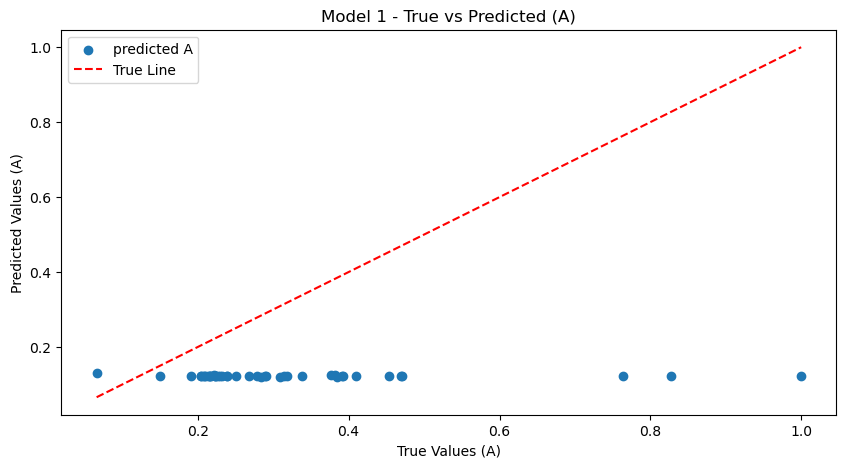

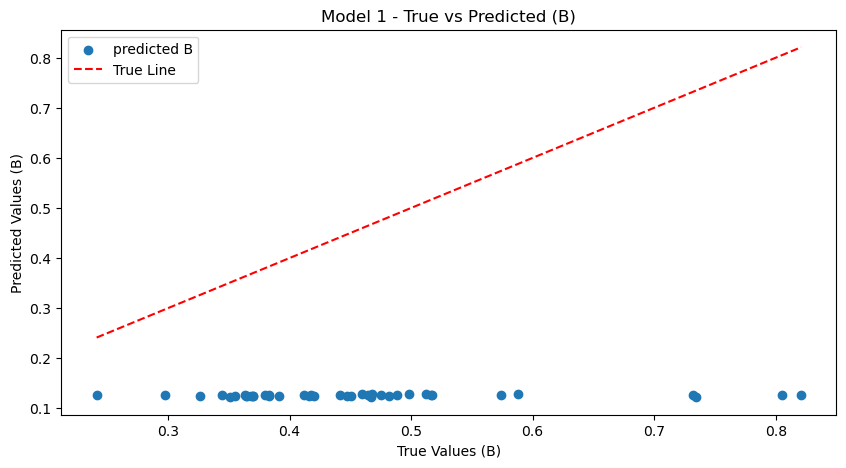

In [60]:
from matplotlib import pyplot as plt

from matplotlib import pyplot as plt

def plot_predicted(test_cycle_life, predicted, model_label):
    plt.figure(figsize=(10, 5))
    plt.scatter(test_cycle_life, predicted, label=f'predicted {model_label}')
    plt.plot([min(test_cycle_life), max(test_cycle_life)], 
             [min(test_cycle_life), max(test_cycle_life)], color='red', linestyle='--', label='True Line')
    plt.title(f'Model 1 - True vs Predicted ({model_label})')
    plt.xlabel(f'True Values ({model_label})')
    plt.ylabel(f'Predicted Values ({model_label})')
    plt.legend()
    plt.show()


with torch.no_grad():
    predicted_a = model(test_Qd_a)
    predicted_b = model(test_Qd_b)
    test_loss_a = criterion(predicted_a, test_cycle_life_a)
    test_loss_b = criterion(predicted_b, test_cycle_life_b)
    print(f'Test Loss A: {test_loss_a.item()}')
    print(f'Test Loss B: {test_loss_b.item()}')

    # 绘制散点图
    plot_predicted(test_cycle_life_a, predicted_a, 'A')
    plot_predicted(test_cycle_life_b, predicted_b, 'B')



In [61]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
cycle_life_a_mean = np.mean(test_cycle_life_a.numpy())
cycle_life_b_mean = np.mean(test_cycle_life_b.numpy())
cycle_life_a_std = np.std(test_cycle_life_a.numpy())
cycle_life_b_std = np.std(test_cycle_life_b.numpy())
# 评估所有模型的性能
results = [] 
    # 计算 RMSE, MAE, R²,rmse/mean,rmse/std,mae/mean,mae/std
rmse_a = np.sqrt(mean_squared_error(test_cycle_life_a, predicted_a))
mae_a = mean_absolute_error(test_cycle_life_a, predicted_a)
r2_a = r2_score(test_cycle_life_a, predicted_a)
    
rmse_b = np.sqrt(mean_squared_error(test_cycle_life_b, predicted_b))
mae_b = mean_absolute_error(test_cycle_life_b, predicted_b)
r2_b = r2_score(test_cycle_life_b, predicted_b)
    
rmse_mean_a = rmse_a / cycle_life_a_mean
rmse_std_a = rmse_a / cycle_life_a_std
mae_mean_a = mae_a / cycle_life_a_mean
mae_std_a = mae_a / cycle_life_a_std
    
rmse_mean_b = rmse_b / cycle_life_b_mean
rmse_std_b = rmse_b / cycle_life_b_std
mae_mean_b = mae_b / cycle_life_b_mean
mae_std_b = mae_b / cycle_life_b_std
    
    # 打印结果
print(f"Model {1} - Test Loss A: {test_loss_a}, RMSE A: {rmse_a}, MAE A: {mae_a}, R² A: {r2_a}")
print(f"Model {1} - Test Loss B: {test_loss_b}, RMSE B: {rmse_b}, MAE B: {mae_b}, R² B: {r2_b}")
    
    # 保存结果
results.append([1, test_loss_a, rmse_a, mae_a, r2_a, test_loss_b, rmse_b, mae_b, r2_b,rmse_mean_a,rmse_std_a,mae_mean_a,mae_std_a,rmse_mean_b,rmse_std_b,mae_mean_b,mae_std_b])
# 创建 CSV 保存评估结果
import csv
with open('model_evaluation_results.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Model', 'Test Loss A', 'RMSE A', 'MAE A', 'R² A', 
                     'Test Loss B', 'RMSE B', 'MAE B', 'R² B','RMSE/Mean A','RMSE/Std A','MAE/Mean A','MAE/Std A','RMSE/Mean B','RMSE/Std B','MAE/Mean B','MAE/Std B'])
    writer.writerows(results)


Model 1 - Test Loss A: 0.06829945743083954, RMSE A: 0.2613416314125061, MAE A: 0.19704581797122955, R² A: -1.2335600534585356
Model 1 - Test Loss B: 0.12545910477638245, RMSE B: 0.3542020618915558, MAE B: 0.33050990104675293, R² B: -6.702644489925489
